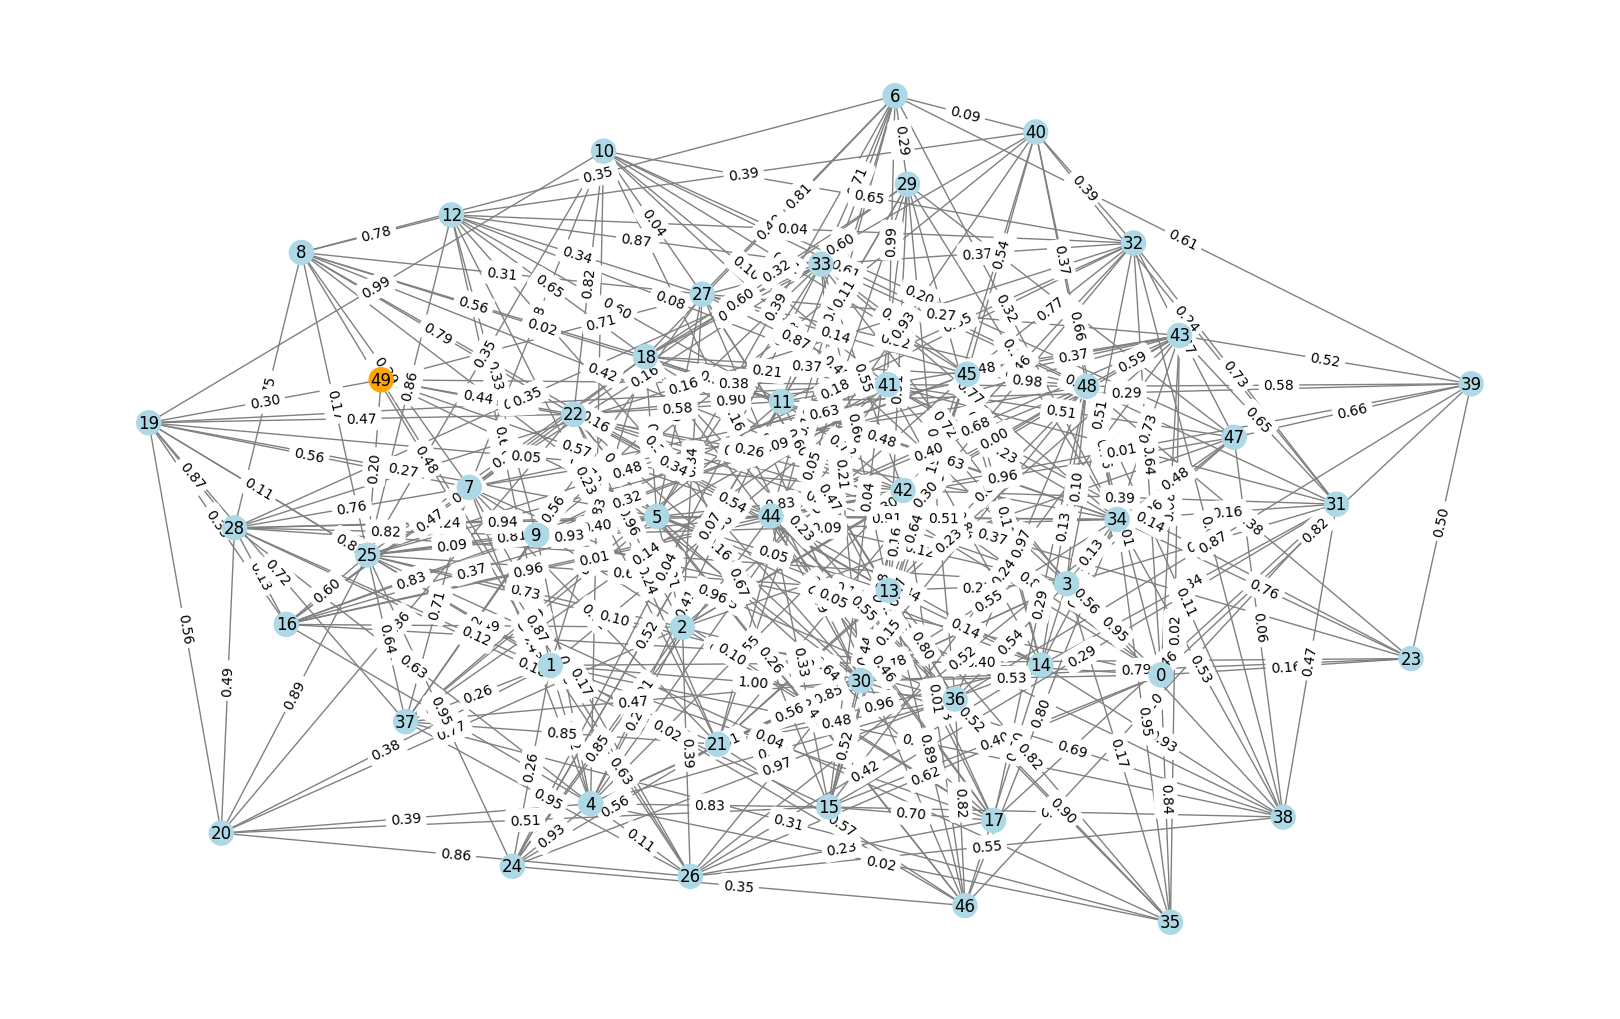

In [1]:
import numpy as np
import networkx as nx
import time
import matplotlib.pyplot as plt

def random_weighted_connected_graph(N, edge_prob=0.3, seed=None, max_tries=100):
    """
    Creates a random undirected connected graph with N nodes, random edge weights in [0,1], and no self-loops.
    edge_prob: probability of edge creation between any two nodes.
    Returns a connected NetworkX graph with 'weight' attributes on edges.
    """
    rng = np.random.default_rng(seed)
    for _ in range(max_tries):
        G = nx.Graph()
        G.add_nodes_from(range(N))
        for i in range(N):
            for j in range(i+1, N):
                if rng.random() < edge_prob:
                    G.add_edge(i, j, weight=rng.random())
        if nx.is_connected(G):
            return G
    raise RuntimeError("Failed to generate a connected graph after max_tries.")

N = 50
edge_prob = 0.3
seed = 1
G = random_weighted_connected_graph(N, edge_prob=edge_prob, seed=seed)


marked_vertex = N - 1


pos = nx.spring_layout(G, seed=seed)
edge_labels = nx.get_edge_attributes(G, 'weight')
edge_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}

node_colors = ['orange' if n == marked_vertex else 'lightblue' for n in G.nodes]

plt.figure(figsize=(16, 10))
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
#plt.title(f"Random Weighted Graph (N={N}, edge_prob={edge_prob})\nMarked vertex: {marked_vertex}")
plt.show()

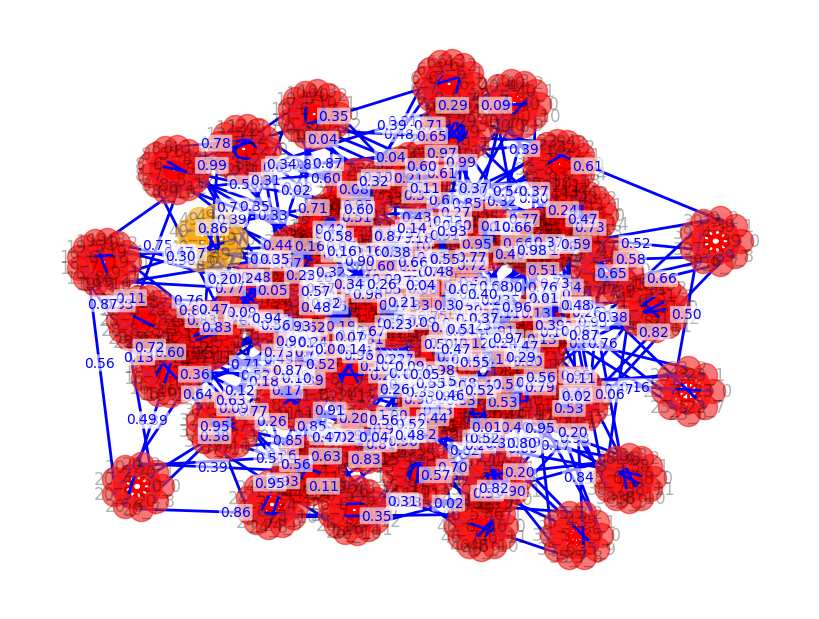

Number of cliques (tessellation 1): 50
Number of 2-cliques (tessellation 2): 359
Example clique: {'0_2', '0_6', '0_7', '0_8', '0_10', '0_3', '0_11', '0_1', '0_12', '0_4', '0_9', '0_0', '0_5', '0_13'}
Example 2-clique: {'3_0', '0_0'}


In [2]:
def clique_expansion_with_layout_and_tessellations(G, pos=None):
    """
    For each vertex v in G, replace it with a clique of size deg(v).
    Each edge (u,v) in G is replaced by an edge between a unique node in the clique of u and a unique node in the clique of v.
    Returns:
        - expanded graph,
        - mapping from original nodes to their clique nodes,
        - layout for visualization,
        - list of cliques (tessellation 1),
        - list of 2-cliques (tessellation 2, one per original edge)
        - neighbor_to_clique_idx (for edge labeling)
    """
    G_exp = nx.Graph()
    node_clique_map = {}

    if pos is None:
        pos = nx.spring_layout(G, seed=42)

    clique_pos = {}
    for v in G.nodes():
        deg = G.degree[v]
        clique_nodes = [f"{v}_{i}" for i in range(deg)]
        G_exp.add_nodes_from(clique_nodes)
        for i in range(deg):
            for j in range(i+1, deg):
                G_exp.add_edge(clique_nodes[i], clique_nodes[j])
        node_clique_map[v] = clique_nodes

        center = np.array(pos[v])
        radius = 0.08
        angles = np.linspace(0, 2 * np.pi, deg, endpoint=False)
        for idx, angle in enumerate(angles):
            offset = radius * np.array([np.cos(angle), np.sin(angle)])
            clique_pos[clique_nodes[idx]] = center + offset

    neighbor_to_clique_idx = {v: {} for v in G.nodes()}
    for v in G.nodes():
        neighbors = sorted(G.neighbors(v))
        for idx, nbr in enumerate(neighbors):
            neighbor_to_clique_idx[v][nbr] = idx

    edge_tess = []
    for u, v in G.edges():
        idx_u = neighbor_to_clique_idx[u][v]
        idx_v = neighbor_to_clique_idx[v][u]
        G_exp.add_edge(node_clique_map[u][idx_u], node_clique_map[v][idx_v])
        edge_tess.append({node_clique_map[u][idx_u], node_clique_map[v][idx_v]})

    clique_tess = [set(clique_nodes) for clique_nodes in node_clique_map.values()]

    return G_exp, node_clique_map, clique_pos, clique_tess, edge_tess, neighbor_to_clique_idx

G_exp, node_clique_map, clique_pos, clique_tess, edge_tess, neighbor_to_clique_idx = clique_expansion_with_layout_and_tessellations(G, pos)

plt.figure(figsize=(8, 6))
nx.draw(G_exp, clique_pos, with_labels=True, node_color='lightgray', edge_color='gray', alpha=0.3)

for v, clique in node_clique_map.items():
    color = 'orange' if v == marked_vertex else 'red'
    nx.draw_networkx_nodes(G_exp, clique_pos, nodelist=list(clique), node_color=color, alpha=0.5)

for v, clique in node_clique_map.items():
    clique_edges = [(u, w) for u in clique for w in clique if u < w and G_exp.has_edge(u, w)]
    edge_color = 'orange' if v == marked_vertex else 'red'
    nx.draw_networkx_edges(G_exp, clique_pos, edgelist=clique_edges, edge_color=edge_color, width=2)

for u, v in G.edges():
    idx_u = neighbor_to_clique_idx[u][v]
    idx_v = neighbor_to_clique_idx[v][u]
    n1 = node_clique_map[u][idx_u]
    n2 = node_clique_map[v][idx_v]
    weight = G[u][v].get('weight', None)
    nx.draw_networkx_edges(G_exp, clique_pos, edgelist=[(n1, n2)], edge_color='blue', width=2)
    if weight is not None:
        x = (clique_pos[n1][0] + clique_pos[n2][0]) / 2
        y = (clique_pos[n1][1] + clique_pos[n2][1]) / 2
        plt.text(x, y, f"{weight:.2f}", color='blue', fontsize=10, ha='center', va='center',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, boxstyle='round,pad=0.1'))

#plt.title("Tessellations: Orange=marked clique, Red=other cliques, Blue=original edges (2-cliques, weighted)")
plt.show()

print(f"Number of cliques (tessellation 1): {len(clique_tess)}")
print(f"Number of 2-cliques (tessellation 2): {len(edge_tess)}")
print("Example clique:", next(iter(clique_tess)))
print("Example 2-clique:", next(iter(edge_tess)))

In [3]:
from math import pi

def get_reflection_operators(G_exp, node_clique_map, edge_tess, G, marked_vertex, theta=pi/2):
    """
    Returns:
        - W_red: reflection matrix for red tessellation (excluding marked clique)
        - W_blue: reflection matrix for blue tessellation (all 2-cliques)
        - node_list: list of node labels (order of basis)
    """
    node_list = list(G_exp.nodes())
    node_index = {node: i for i, node in enumerate(node_list)}
    dim = len(node_list)
    I = np.eye(dim)

    # --- Red tessellation (partial, skip marked clique) ---
    P_red = np.zeros((dim, dim))
    for v, clique in node_clique_map.items():
        if v == marked_vertex:
            continue  # skip marked clique
        weights = []
        basis_indices = []
        for idx, nbr in enumerate(sorted(G.neighbors(v))):
            edge_weight = G[v][nbr]['weight']
            weights.append(np.sqrt(edge_weight))
            basis_indices.append(node_index[clique[idx]])
        weights = np.array(weights)
        norm = np.linalg.norm(weights)
        if norm == 0:
            continue  # skip if isolated
        state = np.zeros(dim)
        state[basis_indices] = weights / norm  # normalized quantum state
        P_red += np.outer(state, state)
    W_red = I - 2 * P_red
    W_red = np.cos(theta) * I + 1j * np.sin(theta) * W_red  # <-- add 1j here

    # --- Blue tessellation (all 2-cliques) ---
    P_blue = np.zeros((dim, dim))
    for edge in edge_tess:
        n1, n2 = list(edge)
        idx1 = node_index[n1]
        idx2 = node_index[n2]
        state = np.zeros(dim)
        state[idx1] = 1/np.sqrt(2)
        state[idx2] = 1/np.sqrt(2)
        P_blue += np.outer(state, state)
    W_blue = I - 2 * P_blue
    W_blue = np.cos(theta) * I + 1j * np.sin(theta) * W_blue  # <-- add 1j here

    return W_red, W_blue, node_list

def get_walker_operator(W_red, W_blue):
    """
    Returns the walker operator W = W_blue @ W_red
    """
    return W_blue @ W_red


In [4]:
def apply_quantum_walk(G_exp, walk_operator, t, initial_state=None):
    """
    Applies the walk operator t times to the initial state on the expanded graph.
    
    Args:
        G_exp: The expanded graph (used to get the node list and dimension).
        walk_operator: The walk operator matrix (should be square of size N x N).
        t: Number of steps (applications of the walk operator).
        initial_state: Optional initial state vector (numpy array of length N).
                       If None, uses the uniform superposition state.
    
    Returns:
        state: The state vector after t steps (numpy array of length N).
    """
    node_list = list(G_exp.nodes())
    N = len(node_list)
    
    # Uniform superposition if not provided
    if initial_state is None:
        state = np.ones(N) / np.sqrt(N)
    else:
        state = initial_state.copy()
    
    for _ in range(t):
        state = walk_operator @ state
    
    return state

In [5]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from math import pi

print("Setting parameters...")
# --- Parameters ---
N = 100 # Number of nodes
edge_prob = 0.5
max_steps = 100  # Number of steps to plot
theta = np.pi / 2  # Example fixed theta
seed = 1


print("Generating random graph...")
# --- Generate random graph and marked vertex ---
G = random_weighted_connected_graph(N, edge_prob, seed)
marked_vertex = N - 1
print("Graph generated. Marked vertex:", marked_vertex)
print("Computing spring layout...")
pos = nx.spring_layout(G, seed=42)

print("Performing clique expansion and tessellations...")
# --- Clique expansion and tessellations ---
G_exp, node_clique_map, clique_pos, clique_tess, edge_tess, neighbor_to_clique_idx = clique_expansion_with_layout_and_tessellations(G, pos)
print("Clique expansion done. Number of expanded nodes:", len(G_exp.nodes()))

print("Building quantum walk operators...")
# --- Build operators ---
W_red, W_blue, node_list = get_reflection_operators(G_exp, node_clique_map, edge_tess, G, marked_vertex, theta)
W = get_walker_operator(W_red, W_blue)
print("Operators built.")

# --- Initial state: uniform superposition ---
N_exp = len(node_list)
psi_0 = np.ones(N_exp) / np.sqrt(N_exp)
print("Initial state prepared. Expanded dimension:", N_exp)

# --- Indices of the marked clique in the expanded graph ---
marked_clique_nodes = node_clique_map[marked_vertex]
marked_indices = [node_list.index(n) for n in marked_clique_nodes]
print("Marked clique indices in expanded graph:", marked_indices)

print("Starting quantum walk...")
# --- Quantum walk and probability tracking ---
probs = []
state = psi_0.copy()
for t in range(max_steps + 1):
    if t % 10 == 0:
        print(f"  Step {t}/{max_steps}...")
    prob = np.sum(np.abs(state[marked_indices])**2)
    probs.append(prob)
    norm = np.linalg.norm(state)
    print(f"    Norm at step {t}: {norm:.10f}")
    if norm > 0:
        state = state / norm  # Normalize the state at every step
    state = W @ state

print("Quantum walk finished. Plotting results...")
# --- Plot ---
plt.figure(figsize=(8, 4))
plt.plot(range(max_steps + 1), probs, marker='o')
plt.xlabel('Number of steps $t$')
plt.ylabel('Probability in marked clique')
plt.title(f'Probability in marked clique vs steps (theta={theta:.2f})')
plt.grid(True)
plt.show()
print("Done.")

Setting parameters...
Generating random graph...
Graph generated. Marked vertex: 99
Computing spring layout...
Performing clique expansion and tessellations...
Clique expansion done. Number of expanded nodes: 4844
Building quantum walk operators...


KeyboardInterrupt: 

Theta cycle 1/41: theta=0.000000, max prob=0.008671
Theta cycle 2/41: theta=0.080554, max prob=0.008671
Theta cycle 3/41: theta=0.161107, max prob=0.008671
Theta cycle 4/41: theta=0.241661, max prob=0.008671
Theta cycle 5/41: theta=0.322215, max prob=0.008915
Theta cycle 6/41: theta=0.402768, max prob=0.009206
Theta cycle 7/41: theta=0.483322, max prob=0.009523
Theta cycle 8/41: theta=0.563876, max prob=0.009799
Theta cycle 9/41: theta=0.644429, max prob=0.010412
Theta cycle 10/41: theta=0.724983, max prob=0.011032
Theta cycle 11/41: theta=0.805537, max prob=0.011938
Theta cycle 12/41: theta=0.886090, max prob=0.013034
Theta cycle 13/41: theta=0.966644, max prob=0.014736
Theta cycle 14/41: theta=1.047198, max prob=0.010970
Theta cycle 15/41: theta=1.127751, max prob=0.020319
Theta cycle 16/41: theta=1.208305, max prob=0.026464
Theta cycle 17/41: theta=1.288859, max prob=0.036533
Theta cycle 18/41: theta=1.369412, max prob=0.058916
Theta cycle 19/41: theta=1.449966, max prob=0.121115
Th

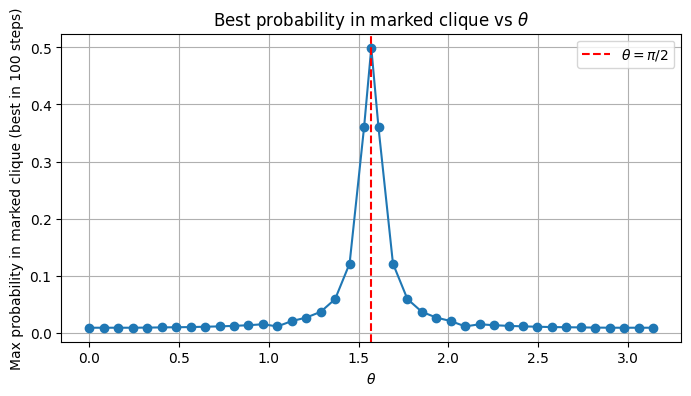

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
N = 100
edge_prob = 0.5
max_steps = 30
seed = 1

# Add pi/2 exactly to the list of theta values (if not already present)
theta_values = np.linspace(0, np.pi, 40)
if not np.any(np.isclose(theta_values, np.pi/2)):
    theta_values = np.sort(np.append(theta_values, np.pi/2))

probs_max = []

# --- Generate random graph and marked vertex ---
G = random_weighted_connected_graph(N, edge_prob, seed)
marked_vertex = N - 1
pos = nx.spring_layout(G, seed=42)

# --- Clique expansion and tessellations ---
G_exp, node_clique_map, clique_pos, clique_tess, edge_tess, neighbor_to_clique_idx = clique_expansion_with_layout_and_tessellations(G, pos)
marked_clique_nodes = node_clique_map[marked_vertex]

for i, theta in enumerate(theta_values):
    # Build operators for this theta
    W_red, W_blue, node_list = get_reflection_operators(
        G_exp, node_clique_map, edge_tess, G, marked_vertex, theta
    )
    W = get_walker_operator(W_red, W_blue)
    N_exp = len(node_list)
    psi_0 = np.ones(N_exp) / np.sqrt(N_exp)
    marked_indices = [node_list.index(n) for n in marked_clique_nodes]
    probs = []
    state = psi_0.copy()
    for t in range(max_steps + 1):
        prob = np.sum(np.abs(state[marked_indices])**2)
        probs.append(prob)
        state = W @ state
    max_prob = np.max(probs)
    probs_max.append(max_prob)
    print(f"Theta cycle {i+1}/{len(theta_values)}: theta={theta:.6f}, max prob={max_prob:.6f}")

plt.figure(figsize=(8, 4))
plt.plot(theta_values, probs_max, marker='o')
plt.axvline(np.pi/2, color='red', linestyle='--', label=r'$\theta = \pi/2$')  # Vertical line at pi/2
plt.xlabel(r'$\theta$')
plt.ylabel('Max probability in marked clique (best in 100 steps)')
plt.title('Best probability in marked clique vs $\\theta$')
plt.grid(True)
plt.legend()
plt.show()

Starting analysis over different N values...

[1/6] Generating 10 graphs with N=40 nodes...
  Graph 1/10 ...
    Max probability is 0.4570. First t within 10%: t=6 (prob=0.4222)
  Graph 2/10 ...
    Max probability is 0.5030. First t within 10%: t=6 (prob=0.4900)
  Graph 3/10 ...
    Max probability is 0.4957. First t within 10%: t=6 (prob=0.4833)
  Graph 4/10 ...
    Max probability is 0.5158. First t within 10%: t=6 (prob=0.4957)
  Graph 5/10 ...
    Max probability is 0.4743. First t within 10%: t=6 (prob=0.4743)
  Graph 6/10 ...
    Max probability is 0.5112. First t within 10%: t=4 (prob=0.4610)
  Graph 7/10 ...
    Max probability is 0.4845. First t within 10%: t=8 (prob=0.4721)
  Graph 8/10 ...
    Max probability is 0.4744. First t within 10%: t=6 (prob=0.4457)
  Graph 9/10 ...
    Max probability is 0.4737. First t within 10%: t=6 (prob=0.4311)
  Graph 10/10 ...
    Max probability is 0.5141. First t within 10%: t=6 (prob=0.4760)

[2/6] Generating 10 graphs with N=60 nodes...


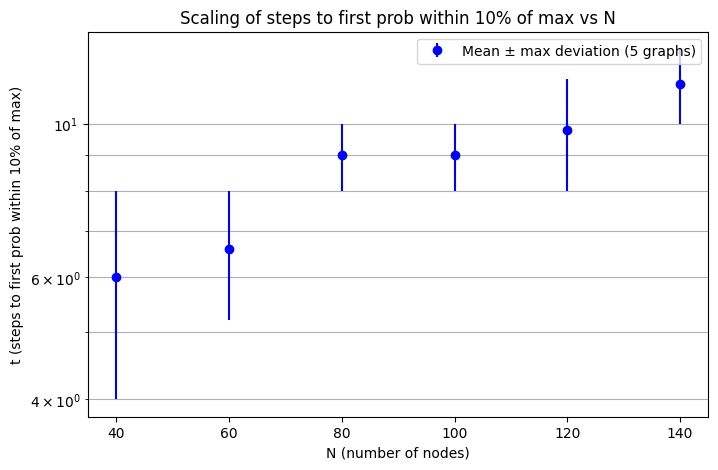

Done.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def find_first_max_index_within_threshold(probs, threshold_ratio=0.9):
    """
    Returns the smallest t such that prob[t] >= threshold_ratio * max_prob.
    """
    max_prob = np.max(probs)
    threshold = threshold_ratio * max_prob
    for t, p in enumerate(probs):
        if p >= threshold:
            return t, max_prob, p
    return np.argmax(probs), max_prob, probs[np.argmax(probs)]

# Data generation (same as before)
Ns = [40, 60, 80, 100, 120, 140]  # Adjusted for better scaling 
max_steps = 30
theta = np.pi / 2
edge_prob = 0.3
num_graphs_per_N = 10

t_max_means = []
t_max_errors = []

print("Starting analysis over different N values...")
for idx, N in enumerate(Ns):
    print(f"\n[{idx+1}/{len(Ns)}] Generating {num_graphs_per_N} graphs with N={N} nodes...")
    t_max_list = []
    for g in range(num_graphs_per_N):
        print(f"  Graph {g+1}/{num_graphs_per_N} ...")
        G = random_weighted_connected_graph(N, edge_prob=edge_prob, seed=None)
        marked_vertex = N - 1
        pos = nx.spring_layout(G, seed=42)
        G_exp, node_clique_map, clique_pos, clique_tess, edge_tess, neighbor_to_clique_idx = clique_expansion_with_layout_and_tessellations(G, pos)
        W_red, W_blue, node_list = get_reflection_operators(G_exp, node_clique_map, edge_tess, G, marked_vertex, theta)
        W = get_walker_operator(W_red, W_blue)
        psi_0 = np.ones(len(node_list)) / np.sqrt(len(node_list))
        marked_clique_nodes = node_clique_map[marked_vertex]
        marked_indices = [node_list.index(n) for n in marked_clique_nodes]

        probs = []
        state = psi_0.copy()
        for t in range(max_steps + 1):
            prob = np.sum(np.abs(state[marked_indices])**2)
            probs.append(prob)
            state = W @ state

        t_max, max_prob, prob_tmax = find_first_max_index_within_threshold(probs, threshold_ratio=0.9)
        print(f"    Max probability is {max_prob:.4f}. First t within 10%: t={t_max} (prob={prob_tmax:.4f})")
        t_max_list.append(t_max)
    t_max_arr = np.array(t_max_list)
    t_max_mean = np.mean(t_max_arr)
    t_max_error = np.max(np.abs(t_max_arr - t_max_mean))
    t_max_means.append(t_max_mean)
    t_max_errors.append(t_max_error)

plt.figure(figsize=(8, 5))
plt.errorbar(Ns, t_max_means, yerr=t_max_errors, fmt='o', color='blue', label='Mean ± max deviation (5 graphs)')
plt.xlabel('N (number of nodes)')
plt.ylabel('t (steps to first prob within 10% of max)')
plt.title('Scaling of steps to first prob within 10% of max vs N')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', axis='y')
plt.show()
print("Done.")

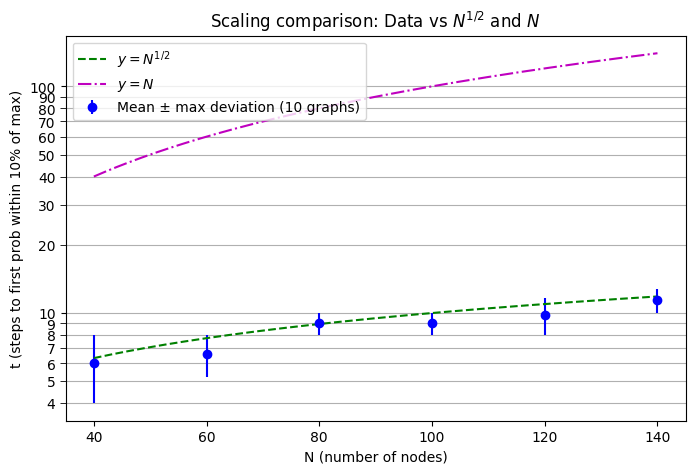

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Cell 8: Compare scaling with y = N^0.5 and y = N ---

# Use the same Ns, t_max_means, and t_max_errors as in the previous cell
Ns_arr = np.array(Ns)
t_max_means_arr = np.array(t_max_means)
t_max_errors_arr = np.array(t_max_errors)

plt.figure(figsize=(8, 5))
plt.errorbar(Ns_arr, t_max_means_arr, yerr=t_max_errors_arr, fmt='o', color='blue', label='Mean ± max deviation (10 graphs)')

# Plot y = N^0.5 and y = N for comparison
N_fine = np.linspace(np.min(Ns_arr), np.max(Ns_arr), 200)
plt.plot(N_fine, N_fine**0.5, 'g--', label=r'$y = N^{1/2}$')
plt.plot(N_fine, N_fine, 'm-.', label=r'$y = N$')

plt.xlabel('N (number of nodes)')
plt.ylabel('t (steps to first prob within 10% of max)')
plt.title('Scaling comparison: Data vs $N^{1/2}$ and $N$')
plt.yscale('log')

# Set more y-ticks for better granularity
from matplotlib.ticker import LogLocator, ScalarFormatter
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0, numticks=15))
plt.gca().yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1, 10)*0.1, numticks=100))
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(ScalarFormatter())
plt.gca().tick_params(axis='y', which='minor', length=4)

plt.legend(loc='upper left')
plt.grid(True, which='both', axis='y')
plt.show()

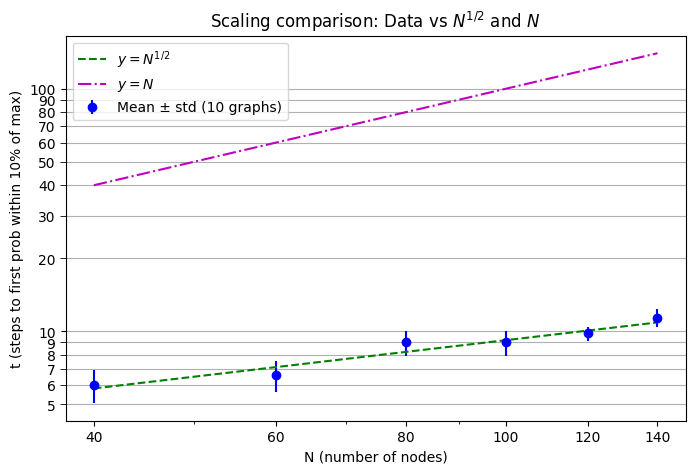

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# --- Data from your prompt ---
Ns = [40, 60, 80, 100, 120, 140]
t_max_lists = [
    [6, 6, 6, 6, 6, 4, 8, 6, 6, 6],      # N=40
    [6, 6, 8, 6, 6, 6, 6, 6, 8, 8],      # N=60
    [10, 10, 8, 10, 8, 8, 10, 10, 8, 8], # N=80
    [8, 8, 10, 8, 8, 10, 10, 10, 8, 10], # N=100
    [10, 10, 10, 8, 10, 10, 10, 10, 10, 10], # N=120
    [12, 10, 12, 12, 12, 10, 12, 10, 12, 12] # N=140
]

# Calculate means and standard deviations
t_max_means = [np.mean(lst) for lst in t_max_lists]
t_max_stds = [np.std(lst, ddof=1) for lst in t_max_lists]  # sample std

Ns_arr = np.array(Ns)
t_max_means_arr = np.array(t_max_means)
t_max_stds_arr = np.array(t_max_stds)

plt.figure(figsize=(8, 5))
plt.errorbar(Ns_arr, t_max_means_arr, yerr=t_max_stds_arr, fmt='o', color='blue', label='Mean ± std (10 graphs)')

# Plot y = N^0.5 and y = N for comparison
N_fine = np.linspace(np.min(Ns_arr), np.max(Ns_arr), 200)
plt.plot(N_fine,0.92 * N_fine**0.5, 'g--', label=r'$y = N^{1/2}$')
plt.plot(N_fine, N_fine, 'm-.', label=r'$y = N$')

plt.xlabel('N (number of nodes)')
plt.ylabel('t (steps to first prob within 10% of max)')
plt.title('Scaling comparison: Data vs $N^{1/2}$ and $N$')
plt.yscale('log')
plt.xscale('log')

# Set x-ticks at your data points, but keep log scale
plt.xticks(Ns, [str(n) for n in Ns])

# Set more y-ticks for better granularity
from matplotlib.ticker import LogLocator, ScalarFormatter
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0, numticks=15))
plt.gca().yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1, 10)*0.1, numticks=100))
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(ScalarFormatter())
plt.gca().tick_params(axis='y', which='minor', length=4)

plt.legend(loc='upper left')
plt.grid(True, which='both', axis='y')
plt.show()

In [ ]:
'''Starting analysis over different N values...

[1/6] Generating 10 graphs with N=40 nodes...
  Graph 1/10 ...
    Max probability is 0.4570. First t within 10%: t=6 (prob=0.4222)
  Graph 2/10 ...
    Max probability is 0.5030. First t within 10%: t=6 (prob=0.4900)
  Graph 3/10 ...
    Max probability is 0.4957. First t within 10%: t=6 (prob=0.4833)
  Graph 4/10 ...
    Max probability is 0.5158. First t within 10%: t=6 (prob=0.4957)
  Graph 5/10 ...
    Max probability is 0.4743. First t within 10%: t=6 (prob=0.4743)
  Graph 6/10 ...
    Max probability is 0.5112. First t within 10%: t=4 (prob=0.4610)
  Graph 7/10 ...
    Max probability is 0.4845. First t within 10%: t=8 (prob=0.4721)
  Graph 8/10 ...
    Max probability is 0.4744. First t within 10%: t=6 (prob=0.4457)
  Graph 9/10 ...
    Max probability is 0.4737. First t within 10%: t=6 (prob=0.4311)
  Graph 10/10 ...
    Max probability is 0.5141. First t within 10%: t=6 (prob=0.4760)

[2/6] Generating 10 graphs with N=60 nodes...
  Graph 1/10 ...
    Max probability is 0.4833. First t within 10%: t=6 (prob=0.4746)
  Graph 2/10 ...
    Max probability is 0.5034. First t within 10%: t=6 (prob=0.4708)
  Graph 3/10 ...
    Max probability is 0.4823. First t within 10%: t=8 (prob=0.4409)
  Graph 4/10 ...
    Max probability is 0.4941. First t within 10%: t=6 (prob=0.4595)
  Graph 5/10 ...
    Max probability is 0.4920. First t within 10%: t=6 (prob=0.4635)
  Graph 6/10 ...
    Max probability is 0.5071. First t within 10%: t=6 (prob=0.4795)
  Graph 7/10 ...
    Max probability is 0.4729. First t within 10%: t=6 (prob=0.4263)
  Graph 8/10 ...
    Max probability is 0.5241. First t within 10%: t=6 (prob=0.4872)
  Graph 9/10 ...
    Max probability is 0.4911. First t within 10%: t=8 (prob=0.4882)
  Graph 10/10 ...
    Max probability is 0.4924. First t within 10%: t=8 (prob=0.4661)

[3/6] Generating 10 graphs with N=80 nodes...
  Graph 1/10 ...
    Max probability is 0.4840. First t within 10%: t=10 (prob=0.4840)
  Graph 2/10 ...
    Max probability is 0.4761. First t within 10%: t=10 (prob=0.4761)
  Graph 3/10 ...
    Max probability is 0.4999. First t within 10%: t=8 (prob=0.4515)
  Graph 4/10 ...
    Max probability is 0.4807. First t within 10%: t=10 (prob=0.4790)
  Graph 5/10 ...
    Max probability is 0.4956. First t within 10%: t=8 (prob=0.4956)
  Graph 6/10 ...
    Max probability is 0.5062. First t within 10%: t=8 (prob=0.4984)
  Graph 7/10 ...
    Max probability is 0.4964. First t within 10%: t=10 (prob=0.4964)
  Graph 8/10 ...
    Max probability is 0.4974. First t within 10%: t=10 (prob=0.4812)
  Graph 9/10 ...
    Max probability is 0.4895. First t within 10%: t=8 (prob=0.4561)
  Graph 10/10 ...
    Max probability is 0.4840. First t within 10%: t=8 (prob=0.4531)

[4/6] Generating 10 graphs with N=100 nodes...
  Graph 1/10 ...
    Max probability is 0.5112. First t within 10%: t=8 (prob=0.4719)
  Graph 2/10 ...
    Max probability is 0.4970. First t within 10%: t=8 (prob=0.4726)
  Graph 3/10 ...
    Max probability is 0.4757. First t within 10%: t=10 (prob=0.4549)
  Graph 4/10 ...
    Max probability is 0.4820. First t within 10%: t=8 (prob=0.4537)
  Graph 5/10 ...
    Max probability is 0.4941. First t within 10%: t=8 (prob=0.4618)
  Graph 6/10 ...
    Max probability is 0.4780. First t within 10%: t=10 (prob=0.4680)
  Graph 7/10 ...
    Max probability is 0.4885. First t within 10%: t=10 (prob=0.4825)
  Graph 8/10 ...
    Max probability is 0.4883. First t within 10%: t=10 (prob=0.4883)
  Graph 9/10 ...
    Max probability is 0.4901. First t within 10%: t=8 (prob=0.4564)
  Graph 10/10 ...
    Max probability is 0.4833. First t within 10%: t=10 (prob=0.4717)

[5/6] Generating 10 graphs with N=120 nodes...
  Graph 1/10 ...
    Max probability is 0.4818. First t within 10%: t=10 (prob=0.4704)
  Graph 2/10 ...
    Max probability is 0.4931. First t within 10%: t=10 (prob=0.4736)
  Graph 3/10 ...
    Max probability is 0.4940. First t within 10%: t=10 (prob=0.4940)
  Graph 4/10 ...
    Max probability is 0.4906. First t within 10%: t=8 (prob=0.4615)
  Graph 5/10 ...
    Max probability is 0.4857. First t within 10%: t=10 (prob=0.4738)
  Graph 6/10 ...
    Max probability is 0.4822. First t within 10%: t=10 (prob=0.4418)
  Graph 7/10 ...
    Max probability is 0.4764. First t within 10%: t=10 (prob=0.4300)
  Graph 8/10 ...
    Max probability is 0.4915. First t within 10%: t=10 (prob=0.4698)
  Graph 9/10 ...
    Max probability is 0.4836. First t within 10%: t=10 (prob=0.4648)
  Graph 10/10 ...
    Max probability is 0.4844. First t within 10%: t=10 (prob=0.4372)

[6/6] Generating 10 graphs with N=140 nodes...
  Graph 1/10 ...
    Max probability is 0.4938. First t within 10%: t=12 (prob=0.4775)
  Graph 2/10 ...
    Max probability is 0.4808. First t within 10%: t=10 (prob=0.4425)
  Graph 3/10 ...
    Max probability is 0.4842. First t within 10%: t=12 (prob=0.4368)
  Graph 4/10 ...
    Max probability is 0.4816. First t within 10%: t=12 (prob=0.4636)
  Graph 5/10 ...
    Max probability is 0.4854. First t within 10%: t=12 (prob=0.4761)
  Graph 6/10 ...
    Max probability is 0.4835. First t within 10%: t=10 (prob=0.4447)
  Graph 7/10 ...
    Max probability is 0.4874. First t within 10%: t=12 (prob=0.4584)
  Graph 8/10 ...
    Max probability is 0.4901. First t within 10%: t=10 (prob=0.4590)
  Graph 9/10 ...
    Max probability is 0.4849. First t within 10%: t=12 (prob=0.4754)
  Graph 10/10 ...
    Max probability is 0.4877. First t within 10%: t=12 (prob=0.4595)'''

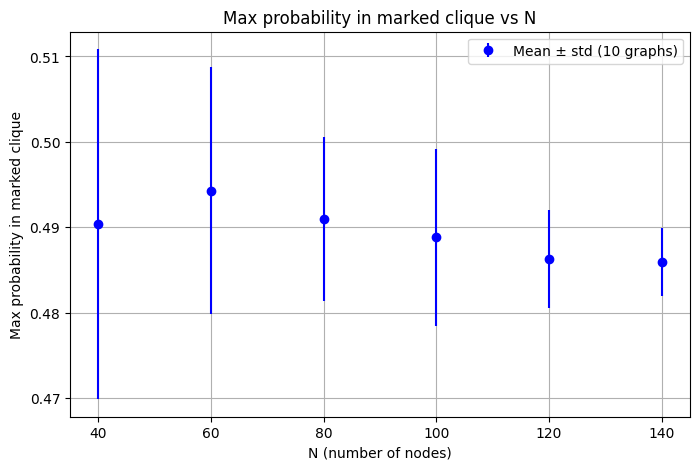

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Data from your output ---
Ns = [40, 60, 80, 100, 120, 140]
probs_max_lists = [
    [0.4570, 0.5030, 0.4957, 0.5158, 0.4743, 0.5112, 0.4845, 0.4744, 0.4737, 0.5141],  # N=40
    [0.4833, 0.5034, 0.4823, 0.4941, 0.4920, 0.5071, 0.4729, 0.5241, 0.4911, 0.4924],  # N=60
    [0.4840, 0.4761, 0.4999, 0.4807, 0.4956, 0.5062, 0.4964, 0.4974, 0.4895, 0.4840],  # N=80
    [0.5112, 0.4970, 0.4757, 0.4820, 0.4941, 0.4780, 0.4885, 0.4883, 0.4901, 0.4833],  # N=100
    [0.4818, 0.4931, 0.4940, 0.4906, 0.4857, 0.4822, 0.4764, 0.4915, 0.4836, 0.4844],  # N=120
    [0.4938, 0.4808, 0.4842, 0.4816, 0.4854, 0.4835, 0.4874, 0.4901, 0.4849, 0.4877],  # N=140
]

# Calculate means and standard deviations
probs_max_means = [np.mean(lst) for lst in probs_max_lists]
probs_max_stds = [np.std(lst, ddof=1) for lst in probs_max_lists]

Ns_arr = np.array(Ns)
probs_max_means_arr = np.array(probs_max_means)
probs_max_stds_arr = np.array(probs_max_stds)

plt.figure(figsize=(8, 5))
plt.errorbar(Ns_arr, probs_max_means_arr, yerr=probs_max_stds_arr, fmt='o', color='blue', label='Mean ± std (10 graphs)')
plt.xlabel('N (number of nodes)')
plt.ylabel('Max probability in marked clique')
plt.title('Max probability in marked clique vs N')
plt.grid(True)
plt.legend()
plt.show()